# Reproducing Hakim CDA Study (2020) - L vs R

### Notes

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_brainvision

from scipy.io import loadmat

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Hakim-2020/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [8]:
#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['int'] = [21, 22] 
triggers['no_int'] = [11, 12]

triggers['left'] = [12, 22]  #[11, 21]
triggers['right'] = [11, 21] #[12, 22]

triggers['good'] = [91]
triggers['bad'] = [90]

# Labels
conds = ['int', 'no_int']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['PO8']
chan_left = ['PO7']

# Epoc Information
epoch_length = 1.65
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable & Reports
cda_dict = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Volumes/Nick - Data/CDA Datasets/Hakim 2020/Experiment 1/EegData/'

eegfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(directory_path)
    for f in files if f.endswith('.vhdr')]

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_brainvision(filepath, preload=True)
    
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Resample
    preproc = raw.resample(500)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)
    events = events[0]
    
    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
    
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['int']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: Int1_2017.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2020/Experiment 1/EegData/1/Int1_2017.vhdr...
Setting channel info structure...
Reading 0 ... 3477439  =      0.000 ...  6954.878 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3477440
    Range : 0 ... 3477439 =      0.000 ...  6954.878

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2942960
    Range : 0 ... 2942959 =      0.000 ...  5885.918

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3369380
    Range : 0 ... 3369379 =      0.000 ...  6738.758

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3765760
    Range : 0 ... 3765759 =      0.000 ...  7531.518

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3772250
    Range : 0 ... 3772249 =      0.000 ...  7544.498

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3486760
    Range : 0 ... 3486759 =      0.000 ...  6973.518

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3661580
    Range : 0 ... 3661579 =      0.000 ...  7323.158

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4787460
    Range : 0 ... 4787459 =      0.000 ...  9574.918

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2836290
    Range : 0 ... 2836289 =      0.000 ...  5672.578

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3096460
    Range : 0 ... 3096459 =      0.000 ...  6192.918

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3365430
    Range : 0 ... 3365429 =      0.000 ...  6730.858

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3736000
    Range : 0 ... 3735999 =      0.000 ...  7471.998

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3052950
    Range : 0 ... 3052949 =      0.000 ...  6105.898

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3297460
    Range : 0 ... 3297459 =      0.000 ...  6594.918

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3531380
    Range : 0 ... 3531379 =      0.000 ...  7062.758

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3876560
    Range : 0 ... 3876559 =      0.000 ...  7753.118

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3289630
    Range : 0 ... 3289629 =      0.000 ...  6579.258

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3179140
    Range : 0 ... 3179139 =      0.000 ...  6358.278

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3252810
    Range : 0 ... 3252809 =      0.000 ...  6505.618

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3538950
    Range : 0 ... 3538949 =      0.000 ...  7077.898

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3508510
    Range : 0 ... 3508509 =      0.000 ...  7017.018

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_43088/6963063.py:50: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=3616270
    Range : 0 ... 3616269 =      0.000 ...  7232.538

,int,no_int,left,right,good,bad,int-left,int-left-good,int-good,int-left-bad,...,no_int-left,no_int-left-good,no_int-good,no_int-left-bad,no_int-bad,no_int-right,no_int-right-good,no_int-right-bad,checksum,notes
Int1_2017.vhdr,300,900,600,600,802,398,150,95,195,55,...,450,319,607,131,293,450,288,162,1,
10_Int1_2017.vhdr,300,900,600,600,682,518,150,82,163,68,...,450,261,519,189,381,450,258,192,1,
11_Int1_2017.vhdr,300,900,600,600,789,411,150,84,179,66,...,450,305,610,145,290,450,305,145,1,
12_Int1_2017.vhdr,300,900,600,600,804,396,150,94,188,56,...,450,304,616,146,284,450,312,138,1,
13_Int1_2017.vhdr,300,900,600,600,685,515,150,87,168,63,...,450,262,517,188,383,450,255,195,1,
14_Int1_2017.vhdr,300,900,600,600,752,448,150,84,164,66,...,450,299,588,151,312,450,289,161,1,
15_Int1_2017.vhdr,300,900,600,600,833,367,150,101,203,49,...,450,309,630,141,270,450,321,129,1,
16_Int1_2017.vhdr,300,900,600,600,732,468,150,89,185,61,...,450,287,547,163,353,450,260,190,1,
17_Int1_2017.vhdr,300,900,600,600,764,436,150,106,196,44,...,450,288,568,162,332,450,280,170,1,
18_Int1_2017.vhdr,300,900,600,600,797,403,150,86,180,64,...,450,310,617,140,283,450,307,143,1,


In [5]:
times = cda_dict['times']
del cda_dict['times']

## 2. Save CDA Data

In [13]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_hakim2020_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [14]:
with open("cda_hakim2020_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

print("Participants: {}, Conditions: {}". format(len(cda_dict), cda_dict[list(cda_dict.keys())[0]].keys()))

Participants: 22, Conditions: dict_keys(['int', 'no_int'])


## 4. Plot CDA Data - Grand CDA Average

In [9]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

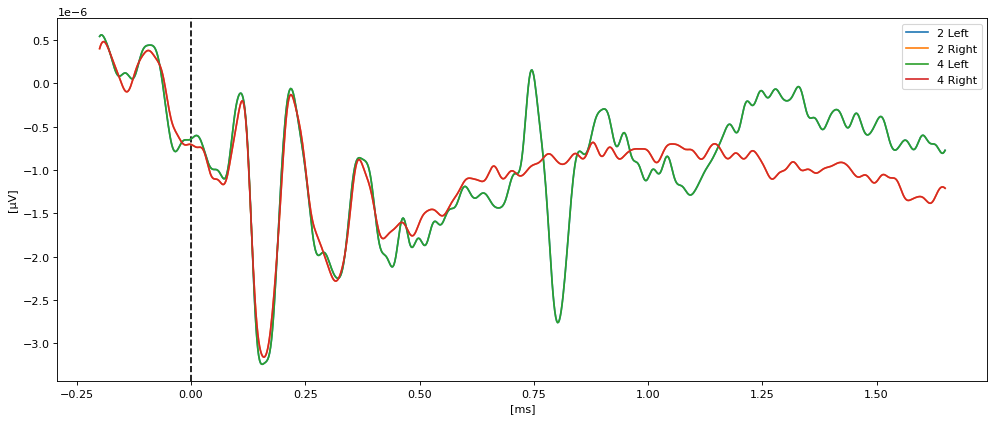

In [6]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['int']['left'].mean(0), label='2 Left')
plt.plot(times, cda_all['no_int']['right'].mean(0), label='2 Right')
plt.plot(times, cda_all['int']['left'].mean(0), label='4 Left')
plt.plot(times, cda_all['no_int']['right'].mean(0), label='4 Right')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()

Text(0.5, 0, '[s]')

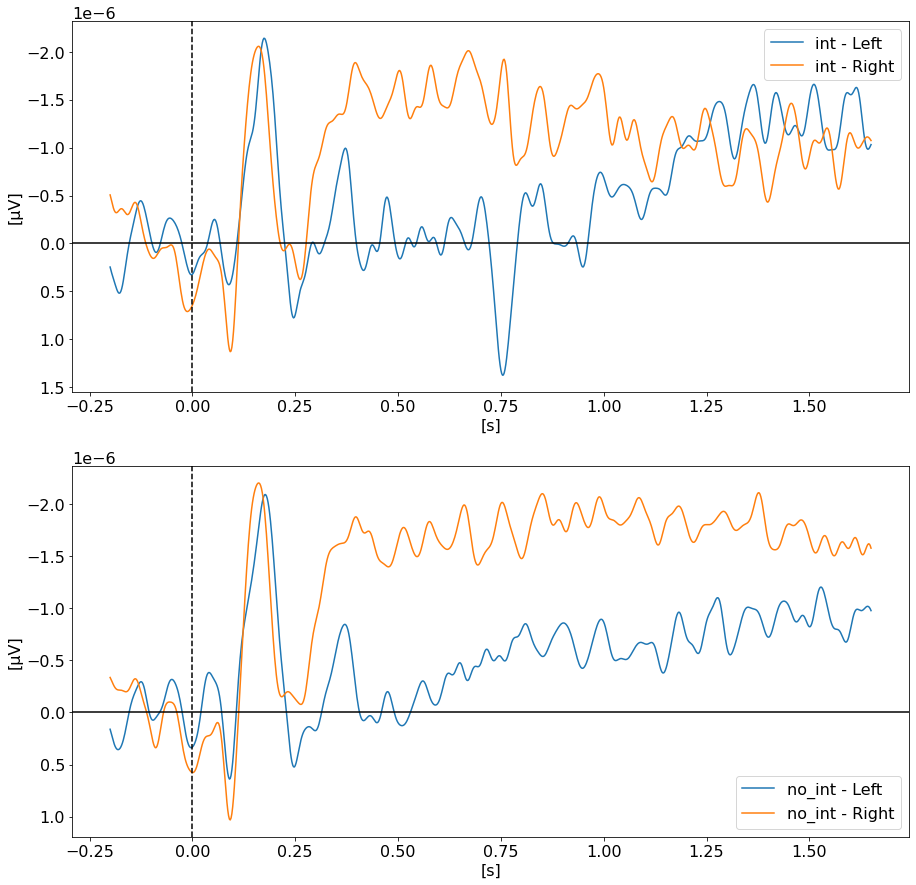

In [10]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['int']['left'].mean(0), label='int - Left')
axs[0].plot(times, cda_all['int']['right'].mean(0), label='int - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['no_int']['left'].mean(0), label='no_int - Left')
axs[1].plot(times, cda_all['no_int']['right'].mean(0), label='no_int - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')